<center><h2>NBA Free Throws Analysis</h2></center>

This notebook contains an analysis of NBA free throws data. 
<br>The data is available at https://www.kaggle.com/sebastianmantey/nba-free-throws

The following libraries are required to run the project and can be installed through pip:
<br>pip install pandas
<br>pip install seaborn
<br>pip install ipywidgets
<br>pip install matplotlib
<br>pip install pandas-profiling[notebook]

In [1]:
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport


pd.options.mode.chained_assignment = None
plt.rcParams['figure.figsize'] = [16, 8]

In [2]:
raw_data = pd.read_csv('free_throws.csv')

### Data familiarisation

Pandas profiling is used to provide a summary of the dataset. Through this summary, it can be noted that the data contains information about 12,874 different games spanning over 10 different seasons. The vast majority of the games (93.5%) are regular games, whilst the remaining 6.5% are playoffs. In total 1098 different players and 34 teams are listed.

The dataset does not contain any missing data, however it has a duplicate row.

In [3]:
# Run a pandas profiling report to explore the data
ProfileReport(raw_data, title='Pandas Profiling Report', explorative=True)

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Data cleaning

In [17]:
# remove duplicate row
data = raw_data.drop_duplicates()

### Feature engineering

In [4]:
# Using REGEX expressions to break down complex column details into more atomic data
data['host_name'] = data.game.str.extract('^(.+?) -')
data['visitor_name'] = data.game.str.extract('-\s(\w+)')
data['host_result'] = data.end_result.str.extract('^(.+?) -').astype(int)
data['visitor_result'] = data.end_result.str.extract('-\s(\w+)').astype(int)
data['host_score'] = data.score.str.extract('^(.+?) -').astype(int)
data['visitor_score'] = data.score.str.extract('-\s(\w+)').astype(int)
data['throw_number'] = data.play.str.extract('([0-9]+) .*').fillna(1).astype(int)
data['throws_given'] = data.play.str.extract('(\d+)(?!.*\d)').fillna(1).astype(int)
data['end_result_diff'] = (data.host_result-data.visitor_result).abs()
data['season_start_yr'] = data.season.str.extract('^(.+?) -').astype(int)
data[['minutes', 'seconds']] = data.time.str.split(':', expand=True).astype(int)
# The time column refers to the time left in the current period. The following new features 
# will convert time to total time elapsed from the start of the game
data['total_minutes'] = (12*(data.period-1)) + (12-data.minutes)
# Creates a code for the team combination, irrespective of which team is the host and which is the visitor
data['teams_code'] = data[['host_name', 'visitor_name']].max(axis=1)+data[['host_name', 'visitor_name']].min(axis=1)

data.head()

,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,...,host_score,visitor_score,throw_number,throws_given,end_result_diff,season_start_yr,minutes,seconds,total_minutes,teams_code
0,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,0 - 1,2006 - 2007,1,...,0,1,1,2,8,2006,11,45,1.0,PHXLAL
1,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,0 - 2,2006 - 2007,1,...,0,2,2,2,8,2006,11,45,1.0,PHXLAL
2,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,18 - 12,2006 - 2007,1,...,18,12,1,2,8,2006,7,26,5.0,PHXLAL
3,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,18 - 12,2006 - 2007,0,...,18,12,2,2,8,2006,7,26,5.0,PHXLAL
4,106 - 114,PHX - LAL,261031013.0,1.0,Shawn Marion makes free throw 1 of 1,Shawn Marion,regular,21 - 12,2006 - 2007,1,...,21,12,1,1,8,2006,7,18,5.0,PHXLAL


### Exploratory Analysis

In [5]:
def plot_period_lines(data):
    plt.plot([12, 12], [min(data), max(data)], '--', c='#7f7f7f');
    plt.plot([24, 24], [min(data), max(data)], '--', c='#7f7f7f');
    plt.plot([36, 36], [min(data), max(data)], '--', c='#7f7f7f');
    plt.plot([48, 48], [min(data), max(data)], '--', c='#7f7f7f');

##### Free throws over time

The following analysis looks at the number of distinct free throws given (i.e free throws with 2 or more shots are counted as 1) over time.

The plot clearly indicates that towards the end of each period, the number of free throws awarded increases. This number increases further at the end of the fourth period.

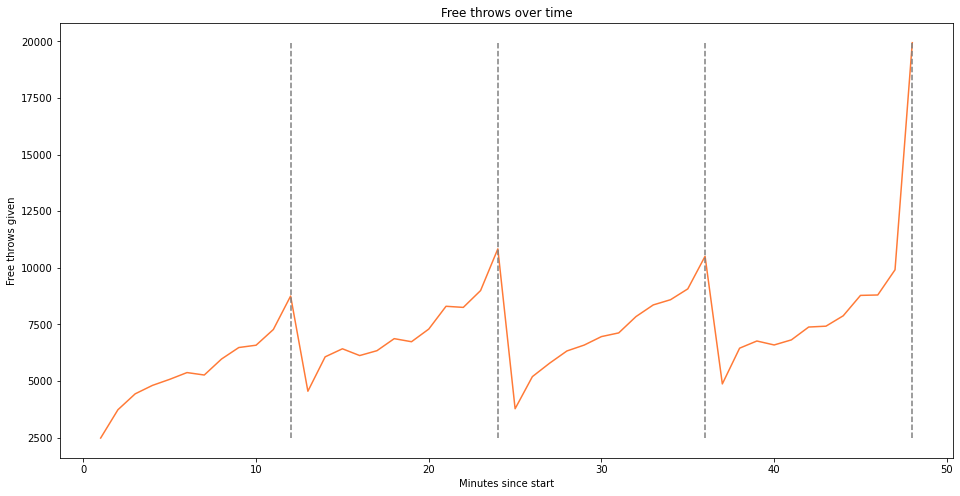

In [6]:
# get distinct free throws in the first four periods
first_four_periods = data[(data.period<=4) & (data.throw_number==1)]
# count the total shots given per minute
shots_vs_minute = first_four_periods.total_minutes.value_counts().sort_index()
ax = sns.lineplot(x=shots_vs_minute.index, y=shots_vs_minute, color='#FF7A37');
ax.set(title='Free throws over time', xlabel='Minutes since start', ylabel='Free throws given');
plot_period_lines(shots_vs_minute)

##### Selected shooter

By plotting the overall free throw accuracy of a player against time, it can be noted that players with higher free-throw accuracy are typically selected for free throws that take place towards the end of the period.

In [7]:
# Calculate the ratio of shots scored vs shots attempted for every player
player_details = data.groupby('player').agg({'shot_made':'sum', 'throw_number':'count'}).reset_index()
player_details['accuracy'] = player_details.shot_made/player_details.throw_number

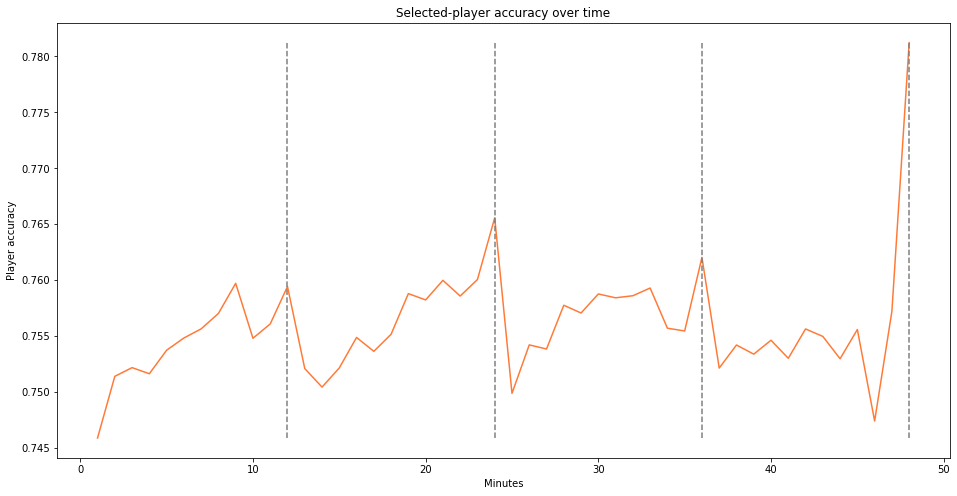

In [8]:
# Join distinct free throws with the player details.
player_shots = pd.merge(data.loc[(data.throw_number==1) & (data.period<=4), ['player', 'total_minutes']], player_details, on='player', how='inner')
# plot player accuracy vs time
avg_acc_vs_time = player_shots.groupby('total_minutes').accuracy.mean()
ax = sns.lineplot(x=avg_acc_vs_time.index, y=avg_acc_vs_time, color='#FF7A37')
ax.set(title='Selected-player accuracy over time', xlabel='Minutes', ylabel='Player accuracy');

plot_period_lines(avg_acc_vs_time)

##### Best free throw takers

Having identified that the most accurate players shoot the free throws towards the end of the period, it is important to know which players have the highest accuracy. The section below rates players according to their accuracy. A filter was set to excluse players who have attempted less than 50 free throws in order to avoid having biased values.

In [9]:
# Select players with at least 50
min_50_throws = player_details[player_details.throw_number>50]
print("Top 5 free throw takers:")
min_50_throws.sort_values('accuracy', ascending=False).head(5)

Top 5 free throw takers:


,player,shot_made,throw_number,accuracy
977,Steve Nash,1454,1591,0.913891
129,Brian Roberts,307,337,0.910979
715,Mario Hezonja,49,54,0.907407
867,Ray Allen,1847,2045,0.903178
165,Chauncey Billups,2518,2793,0.901540


In [10]:
print("Bottom 5 free throw takers:")
min_50_throws.sort_values('accuracy', ascending=True).head(5)

Bottom 5 free throw takers:


,player,shot_made,throw_number,accuracy
589,Justin Williams,31,89,0.348315
158,Cedric Simmons,21,57,0.368421
532,Joey Dorsey,61,162,0.376543
192,Clint Capela,101,268,0.376866
42,Andre Drummond,552,1459,0.378341


##### Talent identification

Identifying players that are showing continuous improvement is a great asset for talent acquisition. Players can be bought at a lower price before reaching their peak performance. 

This section analyses the change in free throw accuracy over time. Continuous increase in free throw accuracy is a sign that the player is still improving.

In [11]:
player_season = data.groupby(['player', 'season_start_yr']).agg({'shot_made':'sum', 'throw_number':'count'}).reset_index()
# exclude players with less than 5 free throws in a season
player_season = player_season[player_season.throw_number>=5]
player_season['accuracy'] = player_season.shot_made/player_season.throw_number

In [12]:
# get seasonal accuracy for players who have shot free throws in each of the last 4 seasons
season_accuracy = pd.pivot_table(player_season, index='season_start_yr', columns='player', values='accuracy').sort_index()
season_accuracy = season_accuracy.iloc[-4:, :].dropna(axis=1)
accuracy_pct_change = season_accuracy.pct_change()

In [13]:
# get the average percentage change in accuracy for the last 4 seasons. 
# Players with high average accuracy show signs of continuous improvement
print('Top 5 improving players:')
accuracy_pct_change.mean().rename('avg_accuracy_change').sort_values(ascending=False).reset_index().head(5)

Top 5 improving players:


,player,avg_accuracy_change
0,Lou Amundson,0.245109
1,Jon Leuer,0.242696
2,Charlie Villanueva,0.224529
3,Ish Smith,0.179826
4,Ian Mahinmi,0.153083


##### Same level teams

Although every game in a tournament is important, the matches against teams of a similar level typically have a larger impact on the final standings in a tournament. Understanding which teams are on the same performance level can be beneficial in ensuring that the best players of the team are not fatigued or injured when facing a team of a similar level.

The analysis below looks at the last 3 years of data to identify which teams typically end the match with very close results. By default, the code below is showing the closest 5 competitors to the Atlanta Hawks (ATL), but the team name can be updated through the drop down widget.

In [14]:
def get_closest_teams(team_name):
    closest_teams = avg_score_diff[avg_score_diff.index.str.contains(team_name)].sort_values().head()
    closest_teams.index = closest_teams.index.str.replace(team_name, '')
    closest_teams = closest_teams.reset_index().rename({'teams_code':'team', 'end_result_diff':'avg_score_diff'}, axis=1)
    return closest_teams

# get unique games from season 2013-2014 onwards
unique_games = data[data.season_start_yr>=2013].drop_duplicates('game_id')
# calculate the average score difference between every 2-team combination
avg_score_diff = unique_games.groupby('teams_code').end_result_diff.mean()

# create drow down widget
team_names = data.host_name.sort_values().unique()
dropdown = widgets.Dropdown(
                options=team_names,
                value='ATL',
                description='Team:',
                disabled=False,
            )
widgets.interact(get_closest_teams, team_name=dropdown);

interactive(children=(Dropdown(description='Team:', options=('ATL', 'BKN', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', …